In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv(r'C:\Users\bendr\Downloads\cwurData.csv')

### Построение графиков распределения

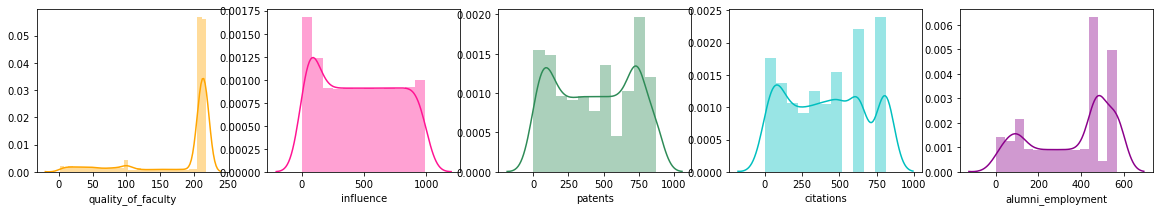

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(20,3))
sns.distplot(df.influence, color='deeppink', ax=axes[1])
sns.distplot(df.quality_of_faculty, color='orange', ax=axes[0])
sns.distplot(df.patents, color='seagreen', ax=axes[2])
sns.distplot(df.citations, color='c', ax=axes[3])
sns.distplot(df.alumni_employment, color='darkmagenta', ax=axes[4])

В целом, почти все независимые переменные распределены равномерно. Отдельно выделяется quality of faculty - ее распределение сильно скошено вправо

Скорее всего это связано с тем, что в рейтинг попала только лучшая 1000 университетов по всему миру. Очевидно, что в мире университетов больше, и все их отразить в рейтинге невозможно, поэтому, возможно, университеты еще перед присуждением мест прошли первичный отбор. Можно предположить, что quality of faculty было решающим  при отборе университетов для рэнкинга

### Проверка на мультиколлинеарность

In [5]:
sub_df = df[['world_rank', 'influence', 'quality_of_faculty', 'patents', 'citations', 'alumni_employment']]
X = sub_df.drop(['world_rank'], axis=1)
Y = df.world_rank
print(X, Y)

      influence  quality_of_faculty  patents  citations  alumni_employment
0             1                   1        5          1                  9
1             4                   3        1          4                 17
2             2                   5       15          2                 11
3            16                   4       50         11                 24
4            22                   7       18         22                 29
...         ...                 ...      ...        ...                ...
2195        845                 218      816        812                567
2196        908                 218      871        645                566
2197        823                 218      824        812                549
2198        974                 218      651        812                567
2199        991                 218      547        812                567

[2200 rows x 5 columns] 0          1
1          2
2          3
3          4
4          5
        ..

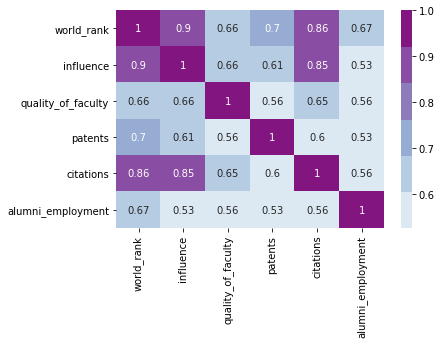

In [6]:
sns.heatmap(sub_df.corr(), cmap=sns.color_palette("BuPu"), annot=True)

Сильно скоррелированы influence и citations (cor = 0.85). Это очевидно, т.к. переменная influence отражает частоту публикаций в очень качественных журналах. Публикация в таких журналах говорит о качестве статьи. Чем лучше статья, тем чаще на нее ссылаются.

Т.к. связь между influence и world_rank сильнее, из модели исключается citations.

In [7]:
X1 = X.drop(['citations'], axis=1)
X1

,influence,quality_of_faculty,patents,alumni_employment
0,1,1,5,9
1,4,3,1,17
2,2,5,15,11
3,16,4,50,24
4,22,7,18,29
...,...,...,...,...
2195,845,218,816,567
2196,908,218,871,566
2197,823,218,824,549
2198,974,218,651,567


### Масштабирование признаков 

In [8]:
# Нормализация

minmax = MinMaxScaler()
minmax.fit(X1)
X1_norm = minmax.transform(X1)
X1_norm

array([[0.        , 0.        , 0.0045977 , 0.01413428],
       [0.0030303 , 0.00921659, 0.        , 0.02826855],
       [0.0010101 , 0.01843318, 0.01609195, 0.01766784],
       ...,
       [0.83030303, 1.        , 0.94597701, 0.96819788],
       [0.98282828, 1.        , 0.74712644, 1.        ],
       [1.        , 1.        , 0.62758621, 1.        ]])

In [9]:
# Стандартизация

stan = StandardScaler()
stan.fit(X1)
X1_stan = stan.transform(X1)
X1_stan

array([[-1.51287139, -2.77792608, -1.56368315, -1.86421115],
       [-1.50297898, -2.74669381, -1.57828519, -1.8213701 ],
       [-1.50957392, -2.71546153, -1.52717804, -1.85350088],
       ...,
       [ 1.19764832,  0.61077548,  1.42608543,  1.02755956],
       [ 1.69556617,  0.61077548,  0.79454701,  1.12395192],
       [ 1.75162315,  0.61077548,  0.41489386,  1.12395192]])

###  Отделение тренировочной и тестовой выборок

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X1_norm, Y, test_size=0.25, random_state=69)

### Обучение линейной модели

In [11]:
mod = LinearRegression()
mod.fit(x_train, y_train)

LinearRegression()

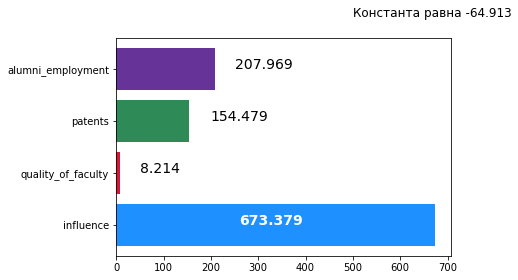

In [12]:
ax = plt.barh(X1.columns, mod.coef_, color = ['dodgerblue', 'crimson', 'seagreen', 'rebeccapurple'])
# дальше код для добавления текста на график
text_inf = plt.text(260, 0, str(round(mod.coef_[0], 3)), color='white', weight='bold', fontsize = 14)
test_qua = plt.text(50, 1, str(round(mod.coef_[1], 3)), fontsize = 14)
test_pat = plt.text(200, 2, str(round(mod.coef_[2], 3)), fontsize = 14)
test_alu = plt.text(250, 3, str(round(mod.coef_[3], 3)), fontsize = 14)
text_int = plt.text(500, 4, f'Константа равна {round(mod.intercept_, 3)}', fontsize = 12)

### Полученное уравнение регрессии:
Представим influence как ***inf***, quality of faculty как ***qua***, patents как ***pat*** и alumni employment как ***alu***

Тогда:
$$\hat{Y} = -65.851 + 675.46 * inf + 13.212 * qua + 153.221 * pat + 201.543 * alu$$

### Коэффициент детерминации и среднеквадратичные ошибки

In [13]:
print("Нахожу коэффициент детерминации и сразу его интерпретирую")
print()
print(f'Коэффициент детерминации для модели на тренировочной выборке равен ~{round(mod.score(x_train, y_train), 4)}')
print(f'В этом случае модель описывает ~{round(mod.score(x_train, y_train)*100, 2)}% выборки')
print(f'Коэффициент детерминации для модели на тестовой выборке равен ~{round(mod.score(x_test, y_test), 4)}')
print(f'В этом случае модель описывает ~{round(mod.score(x_test, y_test)*100, 2)}% выборки')

Нахожу коэффициент детерминации и сразу его интерпретирую

Коэффициент детерминации для модели на тренировочной выборке равен ~0.872
В этом случае модель описывает ~87.2% выборки
Коэффициент детерминации для модели на тестовой выборке равен ~0.8697
В этом случае модель описывает ~86.97% выборки


In [14]:
print('Нахожу СКО по тренировочной выборке')
print()
y_train_pred = mod.predict(x_train)
print(f'СКО равно {round(mean_squared_error(y_train, y_train_pred), 4)}')

Нахожу СКО по тренировочной выборке

СКО равно 11742.6518


In [16]:
print('Нахожу СКО по тестовой выборке')
print()
y_test_pred = mod.predict(x_test)
print(f'СКО равно {round(mean_squared_error(y_test, y_test_pred), 4)}')

Нахожу СКО по тестовой выборке

СКО равно 12372.3577


### Интерпретация
Сильнее всего на world rank влияет influence - при изменении его на 1 world rank меняется на 675.46. Слабее всего влияет quality of faculty - при изменении его на 1 world rank меняется на 13.212. Все предикторы влияют на world rank прямо, т.к. эти показатели тоже ранговые - чем ниже значение, например, influence, тем выше этот показатель (тем выше университет в рейтинге по этому показателю), то же самое актуально для всех переменных в модели, включая world rank.


Модель описывает около 87.05% тренировочной выборки и около 87.28% тестовой выборки.